In [1]:
import pandas as pd
import numpy as np 
from sklearn.metrics import root_mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Creating Hubei Dataset

In [2]:
deaths = pd.read_csv(r"C:\Users\msnin\Downloads\Oden\Oden-github\EnKF Sim + Data\time_series_covid19_deaths_global.csv")
recovered = pd.read_csv(r"C:\Users\msnin\Downloads\Oden\Oden-github\EnKF Sim + Data\time_series_covid19_recovered_global.csv")
confirmed = pd.read_csv(r"C:\Users\msnin\Downloads\Oden\Oden-github\EnKF Sim + Data\time_series_covid19_confirmed_global.csv")

# print(deaths.columns)
# print(deaths.head(2))

In [3]:
hubei_deaths = deaths[deaths['Province/State'] == 'Hubei']
#print(hubei_deaths.head())
hubei_recov = recovered[recovered['Province/State'] == 'Hubei']
hubei_confirm = confirmed[confirmed['Province/State'] == 'Hubei']
#print(hubei_recov.head())
# print(hubei_confirm.head())

In [4]:
# transpose so dates become index for merging
confirm_series = hubei_confirm.drop(
    columns=['Province/State','Country/Region','Lat','Long']
).T.squeeze().rename("Confirmed")
recovered_series = hubei_recov.drop(
    columns=['Province/State','Country/Region','Lat','Long']
).T.squeeze().rename("Recovered")
deaths_series = hubei_deaths.drop(
    columns=['Province/State','Country/Region','Lat','Long']
).T.squeeze().rename("Deaths")

# make index datetime 
confirm_series.index = pd.to_datetime(confirm_series.index)
recovered_series.index = pd.to_datetime(recovered_series.index)
deaths_series.index = pd.to_datetime(deaths_series.index)

# make all series match confirmed cases date index
recovered_series = recovered_series.reindex(confirm_series.index, fill_value=0)
deaths_series = deaths_series.reindex(confirm_series.index, fill_value=0)

hubei_df = pd.concat([confirm_series, recovered_series, deaths_series], axis=1)
hubei_df["Active"] = hubei_df["Confirmed"] - hubei_df["Recovered"] - hubei_df["Deaths"]
hubei_df = hubei_df.reset_index().rename(columns={'index': 'Date'})

print(hubei_df.head())


        Date  Confirmed  Recovered  Deaths  Active
0 2020-01-22        444         28      17     399
1 2020-01-23        444         28      17     399
2 2020-01-24        549         31      24     494
3 2020-01-25        761         32      40     689
4 2020-01-26       1058         42      52     964


C:\Users\msnin\AppData\Local\Temp\ipykernel_43844\132748199.py:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  confirm_series.index = pd.to_datetime(confirm_series.index)


In [5]:
# ADJUSTING TIMEFRAME OF DATA FOR SIMULATION

hubei_df['Date'] = pd.to_datetime(hubei_df['Date'])

beg_date = '2020-01-22' 
end_date = '2020-04-23' #includes both start and end date

filtered_df = hubei_df[(hubei_df['Date'] >= beg_date) & (hubei_df['Date'] <= end_date)].reset_index(drop=True)

print(filtered_df.head())

        Date  Confirmed  Recovered  Deaths  Active
0 2020-01-22        444         28      17     399
1 2020-01-23        444         28      17     399
2 2020-01-24        549         31      24     494
3 2020-01-25        761         32      40     689
4 2020-01-26       1058         42      52     964


# Actual simulation

In [6]:
H = np.array([
    [0, 1, 0, 0],  # I 
    [0, 0, 1, 0],  # R 
    [0, 0, 0, 1]   # D 
])

# paper parameters
n_ens = 200
Y_obs = filtered_df[['Active', 'Recovered', 'Deaths']].to_numpy(dtype = float) # measurement vector on data from our timeframe
T = len(Y_obs)  
N = 59000000  # Hubei population
t_lockdown = 5
dt = 1.0

alpha = 1.0
tol = 1e-3
converged_day = None

rng = np.random.default_rng(seed=100)


In [7]:
# Initial state from day 0
I0 = 399
R0 = 28
D0 = 17
S0 = max(N - I0 - R0 - D0, 0.0)
x0_mean = np.array([S0, I0, R0, D0])  # [S I R D]

def u(lo, hi, size):
    return rng.uniform(lo, hi, size)

def R_from_obs(y_obs): # paper given
    std_devs = 0.1 * np.maximum(y_obs, 1e-2)  
    return np.diag(std_devs ** 2)

def enforce_mass(state_ens, N): # to make sure system is closed st N = S + I + R + D
    np.maximum(state_ens, 0.0, out=state_ens) # always non negative
    total_IRD = state_ens[:, 1:].sum(axis=1)
    
    # sum(I+R+D) <= N, set S = N - (I+R+D)
    ok = total_IRD <= N
    state_ens[ok, 0] = N - total_IRD[ok]
    
    # if sum(I+R+D) > N, rescale I,R,D down to sum to N, set S=0
    over = ~ok
    if np.any(over):
        scale = (N / total_IRD[over])[:, None]
        state_ens[over, 1:] *= scale
        state_ens[over, 0] = 0.0
    return state_ens

# unif dist to sample params from
param_ens = np.column_stack([
    u(0.1,   0.9,   n_ens),  # beta0
    u(0.001, 0.002, n_ens),  # beta1
    u(5.0,   20.0,  n_ens),  # tau_beta
    u(0.001, 0.02,  n_ens),  # gamma0
    u(0.01,  0.1,   n_ens),  # gamma1
    u(7.0,   40.0,  n_ens),  # tau_gamma
    u(0.001, 0.01,  n_ens),  # delta0
    u(0.001, 0.002, n_ens),  # delta1
    u(7.0,   20.0,  n_ens),  # tau_delta
])


In [8]:
ensemble_states_hist = np.full((T, n_ens, 4), np.nan)
ensemble_params_hist = np.full((T, n_ens, 9), np.nan)

def sird_step(state, param, N, day, t_lockdown, dt):
    S, I, R, D = state
    beta0, beta1, tau_beta, gamma0, gamma1, tau_gamma, delta0, delta1, tau_delta = param

    # BETA
    if day < t_lockdown:
        beta = beta0
    else:
        beta = beta0 * np.exp(-(day - t_lockdown)/tau_beta) + beta1

    # GAMMA
    gamma = gamma0 + gamma1 / (1 + np.exp(- (day - tau_gamma)))

    # DELTA
    if day < t_lockdown:
        delta = delta0
    else:
        delta = delta0 * np.exp(-(day - t_lockdown)/tau_delta) + delta1

    dS = - beta * S * I / N
    dI = beta * S * I / N - gamma * I - delta * I
    dR = gamma * I
    dD = delta * I

    S_new = max(S + dS * dt, 0)
    I_new = max(I + dI * dt, 0)
    R_new = max(R + dR * dt, 0)
    D_new = max(D + dD * dt, 0)

    return np.array([S_new, I_new, R_new, D_new])

def predict_measurement(state_ensemble):
    return (H @ state_ensemble.T).T

algo 1. addt. code so multiple passes can be done

In [9]:
max_passes = 10
pass_idx = 0
total_cycles = 0
converged = False
converged_day = None 
num_assm_cycle = 0
converg_in_row = 3  # number of consecutive days to check
converg_counter = 0


while pass_idx < max_passes and not converged: # NEW PASS
        pass_idx += 1
        # reinit ensemble with perterbations
        state_ens = np.zeros((n_ens, 4))
        for i in range(n_ens):
            perturb = 1 + 0.2 * rng.normal(size=3)  # only perturb I, R, D
            IRD = np.maximum(x0_mean[1:] * perturb, 0)
            S = max(N - IRD.sum(), 0)
            state_ens[i] = np.hstack([S, IRD])
        state_ens = enforce_mass(state_ens, N)
        
        # reinit parmams
        param_ens = np.column_stack([
            u(0.1,   0.9,   n_ens),  # beta0
            u(0.001, 0.002, n_ens),  # beta1
            u(5.0,   20.0,  n_ens),  # tau_beta
            u(0.001, 0.02,  n_ens),  # gamma0
            u(0.01,  0.1,   n_ens),  # gamma1
            u(7.0,   40.0,  n_ens),  # tau_gamma
            u(0.001, 0.01,  n_ens),  # delta0
            u(0.001, 0.002, n_ens),  # delta1
            u(7.0,   20.0,  n_ens),  # tau_delta
        ])
        
        converged_day = None
          
        for k in range(T):
            # 1: Forecast step
            num_assm_cycle += 1
            for i in range(n_ens):
                state_ens[i] = sird_step(state_ens[i], param_ens[i], N, k, t_lockdown, dt)
            state_ens = enforce_mass(state_ens, N)

            # Store ensembles
            ensemble_states_hist[k] = state_ens
            ensemble_params_hist[k] = param_ens

            # 2: Measurement prediction
            meas_pred = predict_measurement(state_ens)  # shape (n_ens, 3)

            # 3: Observation perturbation
            y_obs_k = Y_obs[k]
            Rk = R_from_obs(y_obs_k)
            obs_perturbed = rng.multivariate_normal(y_obs_k, Rk, size=n_ens)

            # 4: Augment state and parameters
            aug_ens = np.hstack([state_ens, param_ens])  # shape (n_ens, 13)
            aug_mean = np.mean(aug_ens, axis=0)
            meas_mean = np.mean(meas_pred, axis=0)

            # 5: Compute perturbations
            X = aug_ens - aug_mean  # shape (n_ens, 13)
            Y = meas_pred - meas_mean  # shape (n_ens, 3)

            # 6: Covariance matrices
            C_xy = (X.T @ Y) / (n_ens - 1)      # shape (13, 3)
            C_yy = (Y.T @ Y) / (n_ens - 1)      # shape (3, 3)

            # 7: Kalman gain
            Kk = C_xy @ np.linalg.inv(C_yy + Rk)

            # 8: Analysis update
            for i in range(n_ens):
                innovation = obs_perturbed[i] - meas_pred[i]
                aug_update = aug_ens[i] + alpha * (Kk @ innovation)
                state_ens[i] = aug_update[:4]
                param_ens[i] = aug_update[4:]
            state_ens = enforce_mass(state_ens, N)

            # Persist ensembles for this step
            ensemble_states_hist[k] = state_ens
            ensemble_params_hist[k] = param_ens

            # 9: Check convergence 
            if k > 0:
                prev_mean_theta = np.mean(ensemble_params_hist[k-1], axis=0)
                curr_mean_theta = np.mean(param_ens, axis=0)
                rel_change = np.linalg.norm(curr_mean_theta - prev_mean_theta) / (np.linalg.norm(prev_mean_theta) + 1e-9)
                if rel_change < tol:
                    converg_counter += 1
                    
                    if converg_counter == converg_in_row:
                        converged_day = k
                        print(f"Pass {pass_idx} converged at day {converged_day}")
                        print(f'Converged after {num_assm_cycle} assimilation cycles')
                        break
                else: 
                    converg_counter = 0

        # Extract mean states up to last_day
        last_day = converged_day if converged_day is not None else T - 1
        mean_states = np.nanmean(ensemble_states_hist[: last_day + 1], axis=1)
        
        total_cycles += (converged_day + 1) if converged_day is not None else T

        if converged_day is not None:
            converged = True
        else:
            print(f"Pass {pass_idx} did not converge after {T} days, restarting with new ensemble")

if not converged:
    print(f"Did not converge after {max_passes} passes (total cycles = {total_cycles})")


Pass 1 did not converge after 93 days, restarting with new ensemble
Pass 2 did not converge after 93 days, restarting with new ensemble
Pass 3 did not converge after 93 days, restarting with new ensemble
Pass 4 did not converge after 93 days, restarting with new ensemble
Pass 5 did not converge after 93 days, restarting with new ensemble
Pass 6 converged at day 81
Converged after 547 assimilation cycles


In [10]:
# get observed data and predictions
actual_I = Y_obs[: last_day + 1, 0]
actual_R = Y_obs[: last_day + 1, 1]
actual_D = Y_obs[: last_day + 1, 2]

pred_I = mean_states[:, 1]
pred_R = mean_states[:, 2]
pred_D = mean_states[:, 3]

def clean_nans(y_true, y_pred):
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    return y_true[mask], y_pred[mask]

actual_I, pred_I = clean_nans(actual_I, pred_I)
actual_R, pred_R = clean_nans(actual_R, pred_R)
actual_D, pred_D = clean_nans(actual_D, pred_D)

Infected:   R^2=0.9805, RMSE=2370.45
Recovered:  R^2=0.9989, RMSE=883.25
Deceased:   R^2=0.9951, RMSE=82.02
convergence 81
converged after 547 assim cycles


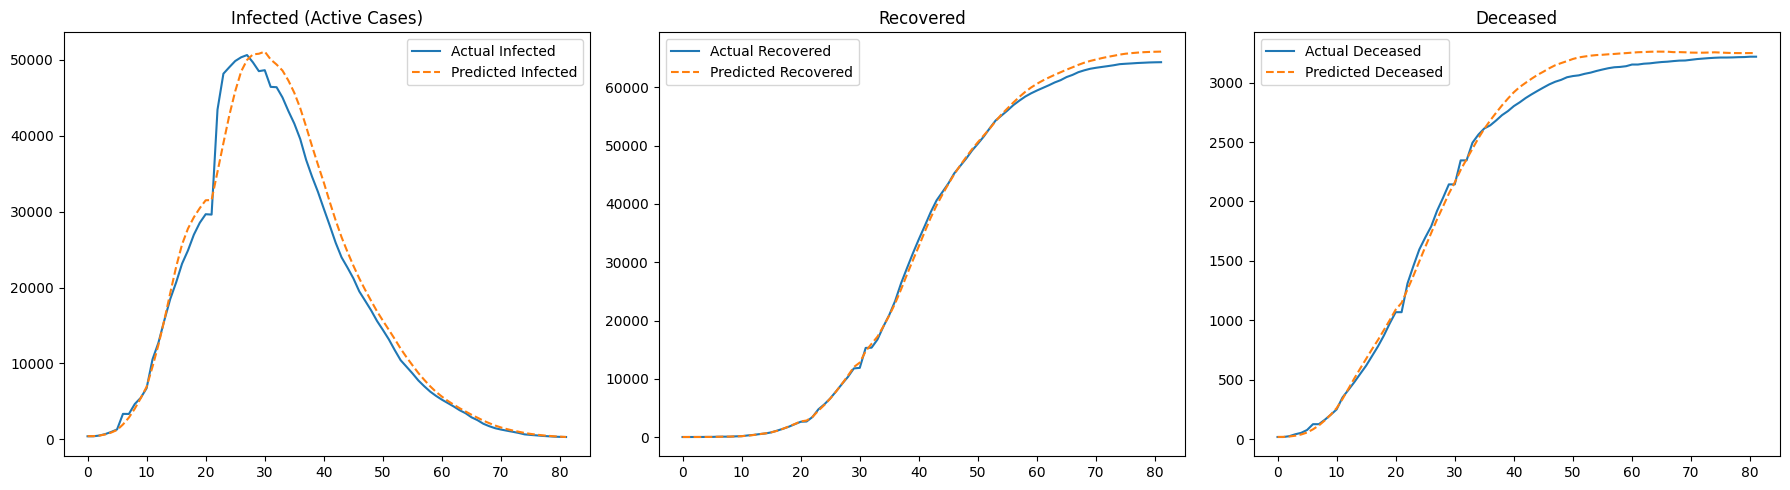

In [11]:
print(f"Infected:   R^2={r2_score(actual_I, pred_I):.4f}, RMSE={root_mean_squared_error(actual_I, pred_I):.2f}")
print(f"Recovered:  R^2={r2_score(actual_R, pred_R):.4f}, RMSE={root_mean_squared_error(actual_R, pred_R):.2f}")
print(f"Deceased:   R^2={r2_score(actual_D, pred_D):.4f}, RMSE={root_mean_squared_error(actual_D, pred_D):.2f}")
print('convergence', converged_day)
print(f'converged after {num_assm_cycle} assim cycles')

plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
plt.plot(actual_I, label='Actual Infected')
plt.plot(pred_I, '--', label='Predicted Infected')
plt.legend()
plt.title('Infected (Active Cases)')

plt.subplot(1,3,2)
plt.plot(actual_R, label='Actual Recovered')
plt.plot(pred_R, '--', label='Predicted Recovered')
plt.legend()
plt.title('Recovered')

plt.subplot(1,3,3)
plt.plot(actual_D, label='Actual Deceased')
plt.plot(pred_D, '--', label='Predicted Deceased')
plt.legend()
plt.title('Deceased')

plt.tight_layout()
plt.show()

plot each greek over time

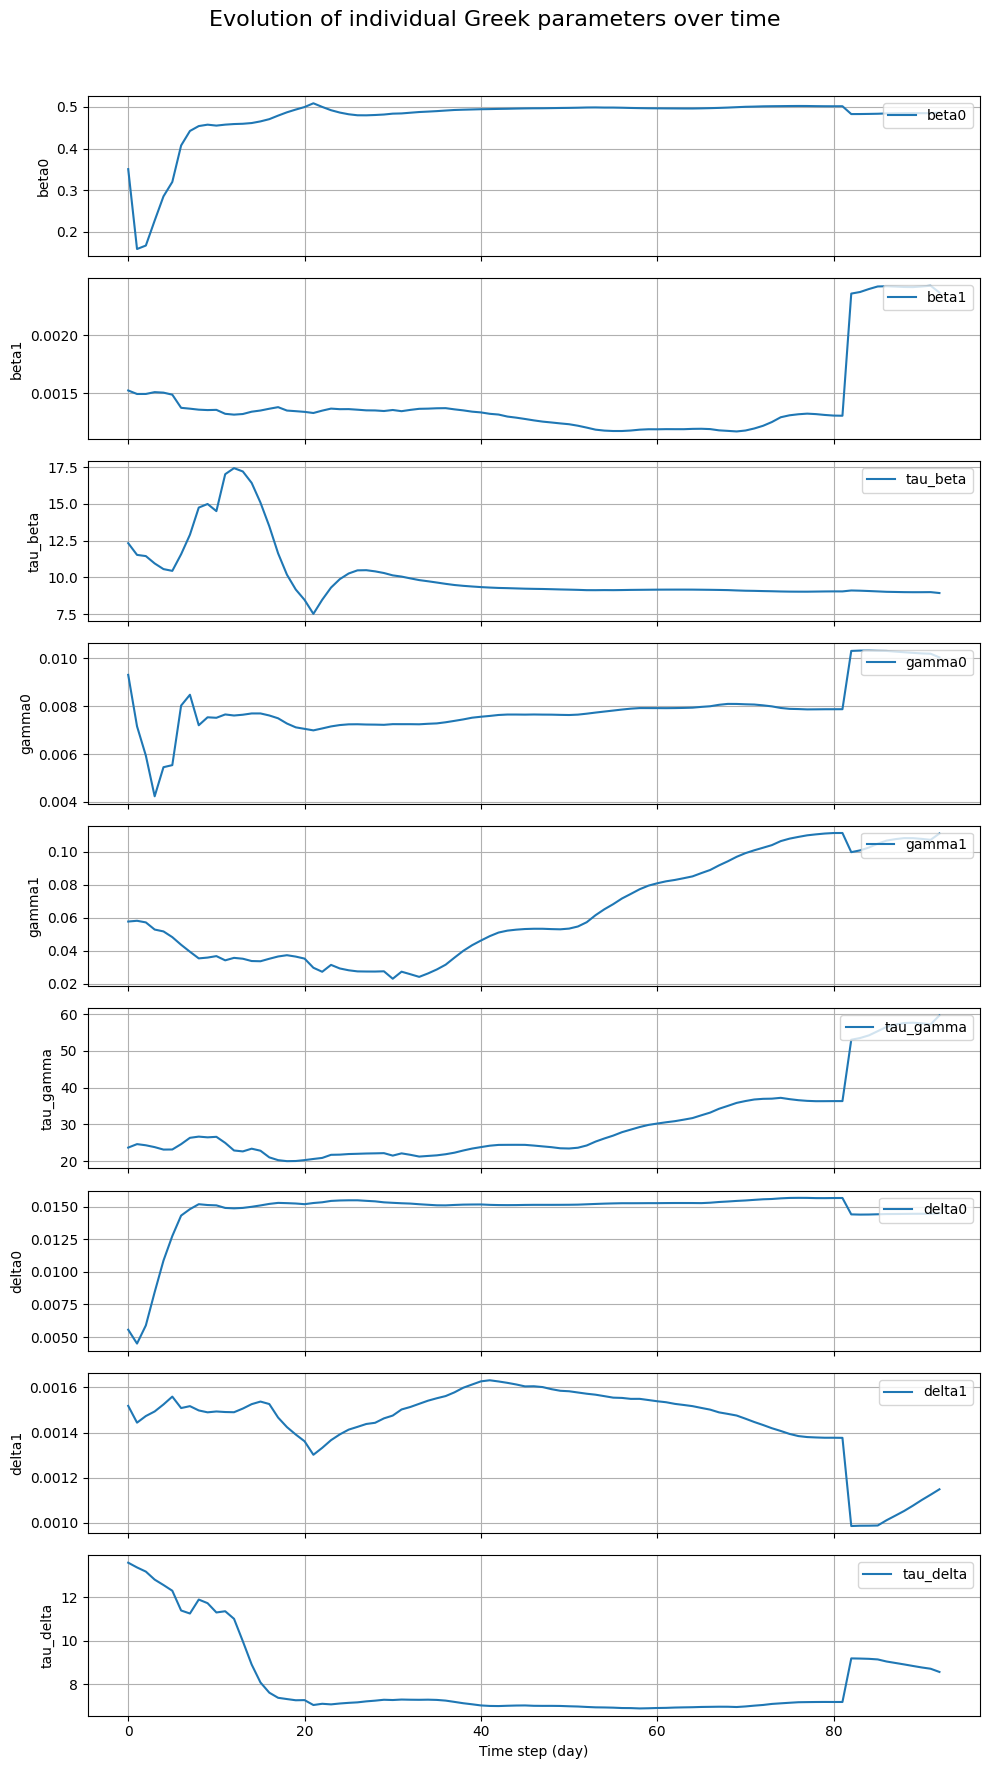

In [12]:
import matplotlib.pyplot as plt
import numpy as np

mean_params_time = np.nanmean(ensemble_params_hist, axis=1)  # shape (T, 9)

param_names = [
    'beta0', 'beta1', 'tau_beta',
    'gamma0', 'gamma1', 'tau_gamma',
    'delta0', 'delta1', 'tau_delta'
]

T = mean_params_time.shape[0]
time_steps = np.arange(T)

fig, axes = plt.subplots(9, 1, figsize=(10, 18), sharex=True)

for i, ax in enumerate(axes):
    ax.plot(time_steps, mean_params_time[:, i], label=param_names[i])
    ax.set_ylabel(param_names[i])
    ax.legend(loc='upper right')
    ax.grid(True)

axes[-1].set_xlabel('Time step (day)')
plt.suptitle('Evolution of individual Greek parameters over time', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
